# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.

In [18]:
BATCHES_DIR = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report'
TEST_CONFIG_FILE = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/default.yml'

In [19]:
# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml

from processor import analysis, reports

from IPython.display import display

base_directory = BATCHES_DIR
with open(TEST_CONFIG_FILE) as fp:
    batch_description = yaml.load(fp)
batch_description

{'intervals': [{'duration_minutes': 60, 'speed_percentage': 0},
  {'duration_minutes': 60, 'speed_percentage': 25},
  {'duration_minutes': 60, 'speed_percentage': 50},
  {'duration_minutes': 60, 'speed_percentage': 75},
  {'duration_minutes': 60, 'speed_percentage': 100},
  {'duration_minutes': 60, 'speed_percentage': 0}],
 'max_speed_kBs': 1000,
 'start_time': 1543125600.114527}

In [20]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    
    test_start_epoch = batch_description['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in batch_description['intervals']:
        lapse = experiment_configuration['duration_minutes'] * 60
        start = experiment_start_epoch
        end = experiment_start_epoch + lapse
        
        if start <= batch_start_time < end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = start
        if start <= batch_end_time < end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = end
        
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        # TODO actualizar esta parte con el nuevo yml
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    return expected_usage
    

In [21]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    print('Analyzing reports {}'.format(reports_batch_dir_path))
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543125613
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543126544
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543127476
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543128411
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543129462
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543130668
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543131858
Analyzing reports /home/gaston/workspace/taller-3/tix/CalibrationTestLogs/logs-rasp3-25nov2018/batch-test-report/1543132990
Analyzin

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1543125613,1543127413,2018-11-25 03:00:13,2018-11-25 03:30:13,0.569576,0.210206,1.0,0.115523,0.480256,0.197953,1.0,0.518116,0.000000,0.115523,0.115523
1,1543126544,1543127934,2018-11-25 03:15:44,2018-11-25 03:38:54,0.579007,0.426998,1.0,0.115578,0.547603,0.595537,1.0,0.605911,0.000000,0.115578,0.115578
2,1543127476,1543129104,2018-11-25 03:31:16,2018-11-25 03:58:24,0.547570,0.655956,1.0,0.128920,0.552582,0.649516,1.0,0.511719,0.000000,0.128920,0.128920
3,1543128411,1543130398,2018-11-25 03:46:51,2018-11-25 04:19:58,0.566704,0.518551,1.0,0.314136,0.499770,0.512360,1.0,0.804545,0.150715,0.163421,1.084301
4,1543129462,1543131684,2018-11-25 04:04:22,2018-11-25 04:41:24,0.470375,0.552348,1.0,0.253012,0.563516,0.236172,1.0,0.812183,0.250000,0.003012,0.012048
5,1543130668,1543132820,2018-11-25 04:24:28,2018-11-25 05:00:20,0.457502,0.273644,1.0,0.226131,0.487317,0.282980,1.0,0.860262,0.252310,0.026179,0.103759
6,1543131858,1543134054,2018-11-25 04:44:18,2018-11-25 05:20:54,0.540514,-0.061380,1.0,0.318182,0.580336,0.401448,1.0,0.866337,0.392747,0.074565,0.189855
7,1543132990,1543135016,2018-11-25 05:03:10,2018-11-25 05:36:56,0.587816,1.238135,1.0,0.292793,0.520295,0.614944,1.0,0.833333,0.500000,0.207207,0.414414
8,1543134130,1543135918,2018-11-25 05:22:10,2018-11-25 05:51:58,0.477734,0.751240,1.0,0.250000,0.543410,0.290111,1.0,0.847222,0.500000,0.250000,0.500000
9,1543135258,1543136933,2018-11-25 05:40:58,2018-11-25 06:08:53,0.478703,0.359874,1.0,0.357843,0.499965,0.973692,1.0,0.846154,0.579535,0.221692,0.382534


<IPython.core.display.Javascript object>


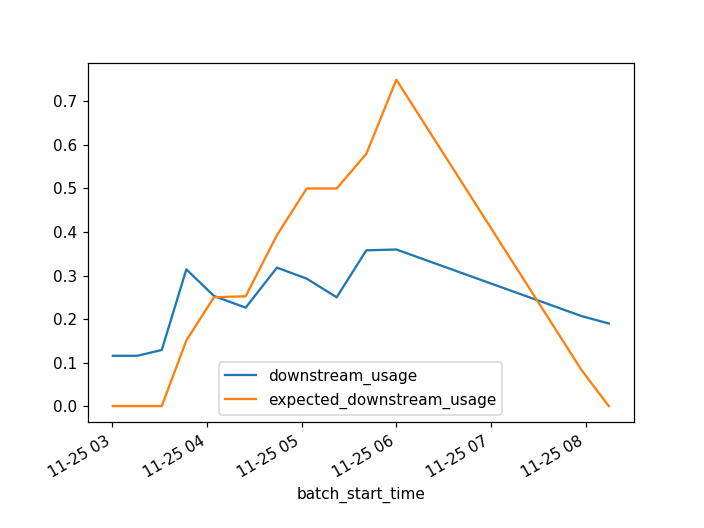

In [22]:
data.plot(x='batch_start_time', y=['downstream_usage', 'expected_downstream_usage'], kind='line')

In [23]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,13.000000,13.000000
mean,0.154646,0.405190
std,0.101520,0.436669
min,0.003012,0.012048
25%,0.115523,0.115578
50%,0.128920,0.189855
75%,0.207207,0.500000
max,0.390174,1.510551


<IPython.core.display.Javascript object>


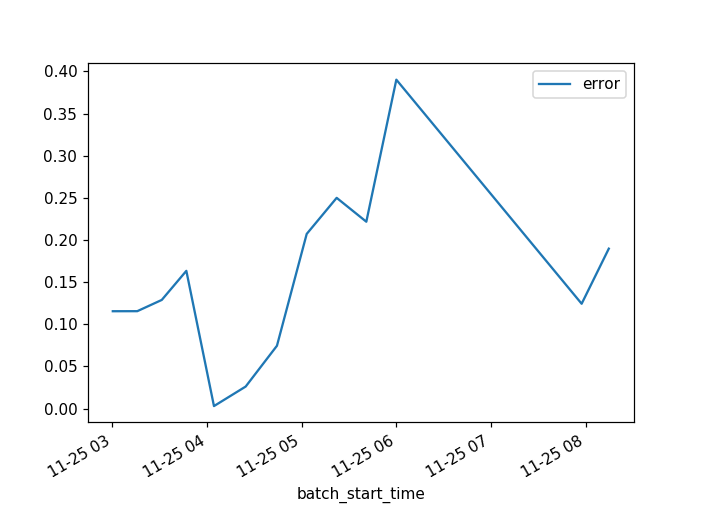

In [24]:
data.plot(x='batch_start_time', y='error', kind='line')

<IPython.core.display.Javascript object>


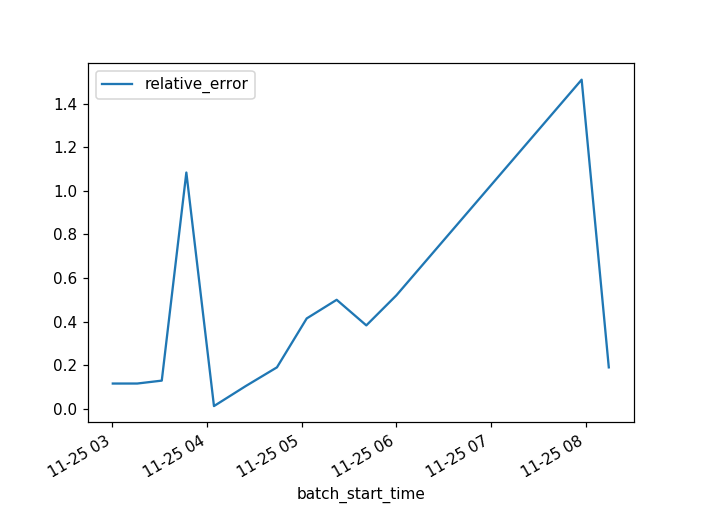

In [13]:
data.plot(x='batch_start_time', y='relative_error', kind='line')